In [1]:
import scipy 
import sympy as sm
import sympy.physics.mechanics as me
from scipy.io import loadmat 
import numpy as np
from odetmt import odetmt 
from rk4 import rk4

########### Loading relevant data ##############

participant = 'Paul-Yme' #change this to the desired participant 
file = 'Lap Fast 3'

#loading the data from the measured participants 
info = loadmat('info.mat') #upload the other info.mat files with the right names
info_data = info['info']

names = []
for sub_array in info_data[0]['names'][0]:
    for name in sub_array:
        names.append(name[0])
print(f"names = {names}")

masses = []  
for mass in info_data[0]['meetschaats'][0]: 
    masses.append(mass[0]) #array of the masses of all the participants 
print(f"masses = {masses}")

idx = names.index(participant)
m_skater = masses[idx]
print(f"m_skater = {m_skater}")

data = scipy.io.loadmat('processed_data_P4.mat')
measured_forces = scipy.io.loadmat('measured_forces_P4.mat')
POS, VEL, freqMS, q, skate_Array, q1 = data['POS'], data['VEL'], data['freqMS'], data['q'], data['skate_Array'], data['q1']
GForceLS, GForceRS, LSFl, LSFn, RSFl, RSFn = measured_forces['GForceLS'], measured_forces['GForceRS'], measured_forces['LSFl'], measured_forces['LSFn'], measured_forces['RSFl'], measured_forces['RSFn']

#Constants 
alpha = 0.1 #mass distribution coefficient: mass distribution between skate and upper limb 
fric_coef = 0.15 #air friction coefficient 
mu = 0.003 #ice friction coefficient 
g  = 9.81 

h = 1
T = len(VEL[0,:])
N = int(T/h) 
iter2 = 3 
iter = 2 

b0 = np.zeros((N, 6))
b0[0, :] = [POS[0, 0], POS[1, 0], POS[2, 0], VEL[0, 0], VEL[1, 0], VEL[2, 0]]
xb, yb, zb, dxb, dyb, dzb = b0[0,:]
 
k = 0 
SkateLabdas = np.zeros((N-1, 1)) 
SkateForces = np.zeros((N-1, 3))  
Q = np.zeros((N-1, 3))            
Fi = np.zeros((N-1, 6))           
F_wrijv = np.zeros((N-1, 1))     
F_wrijvb = np.zeros((N-1, 1))    
b0dot = np.zeros((N, 6))          
thetab = np.zeros((N-1, 1))     

#for i in range(N):
for i in range(N-1):
#for i in range(1):
    q2 = q1[k:k+iter2, :] #select 3 consecutive rows 
    
    if skate_Array[0,i] == 1:
        skate = 'LS'
    elif skate_Array[0,i] == 2:
        skate = 'RS'
    else:
        continue

    b0[i+1, :], SkateLabdas[i, :], SkateForces[i, :], Q[i, :], Fi[i, :], F_wrijv[i, :], F_wrijvb[i, :], b0dot[i+1, :], thetab[i, :] = rk4(b0[i, :], q2, h, freqMS, m_skater, alpha, fric_coef, mu, skate, q[i+1, :])

    k = k + iter 


names = ['Thijs', 'Lucas', 'Manon', 'Aron', 'Lotte', 'Martijn', 'Paul-Yme', 'Arvin']
masses = [83, 84, 65, 82, 70, 76, 81, 76]
m_skater = 81


In [2]:
SkateForces

array([[ -90.26049148,    5.62033464,  -14.9110754 ],
       [ -81.22117084,  -85.25205605,  -19.43141569],
       [ -67.11731458, -168.20855464,  -23.51547059],
       ...,
       [-135.8661617 , 1698.81155734,  173.17667515],
       [-161.69234005, 1526.86128489,  162.64985265],
       [-178.81391641, 1282.39438874,  145.75688412]])

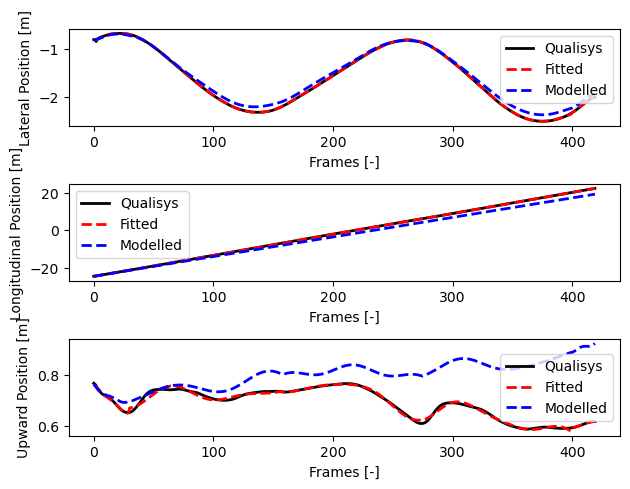

In [4]:
import matplotlib.pyplot as plt

#Measured generalized coordinates
from Generalized_coord_measured import gen_coord_meas 
THETA_B, THETA_LS, THETA_RS, VLS, ULS, WLS, VRS, URS, WRS = gen_coord_meas(POS, VEL, T)

qualysis_data = scipy.io.loadmat('Qualysis_data_P4.mat') #loading the measured Qualysis data for measured positions
qualysis_data.keys()
keys = ['LSroll', 'LSyaw', 'RSroll', 'RSyaw', 'VDDXB', 'VDDXLS', 'VDDXRS', 'VDDYB', 'VDDYLS', 'VDDYRS', 'VDDZB', 'VDDZLS', 'VDDZRS', 'VDXB', 'VDXLS', 'VDXRS', 'VDYB', 'VDYLS', 'VDYRS', 'VDZB', 'VDZLS', 'VDZRS', 'XB', 'XLS', 'XRS', 'YB', 'YLS', 'YRS', 'ZB', 'ZLS', 'ZRS']

for key in keys:
    locals()[key] = qualysis_data[key]

######################### Plotting the position ############################
plt.figure()

# First subplot
plt.subplot(311) #X position body
plt.plot(XB, 'k', linewidth=2, label='Qualisys')
plt.plot(POS[0, :], '--r', linewidth=2, label='Fitted')
plt.plot(b0[:, 0], '--b', linewidth=2, label='Modelled')
plt.legend()
plt.ylabel('Lateral Position [m]')
plt.xlabel('Frames [-]')

# Second subplot
plt.subplot(312) #Y position body 
plt.plot(YB, 'k', linewidth=2, label='Qualisys')
plt.plot(POS[1, :], '--r', linewidth=2, label='Fitted')
plt.plot(b0[:, 1], '--b', linewidth=2, label='Modelled')
plt.legend()
plt.ylabel('Longitudinal Position [m]')
plt.xlabel('Frames [-]')

# Third subplot
plt.subplot(313) #Z position body
plt.plot(ZB, 'k', linewidth=2, label='Qualisys')
plt.plot(POS[2, :], '--r', linewidth=2, label='Fitted')
plt.plot(b0[:, 2], '--b', linewidth=2, label='Modelled')
plt.legend()
plt.ylabel('Upward Position [m]')
plt.xlabel('Frames [-]')

plt.tight_layout()
plt.show()


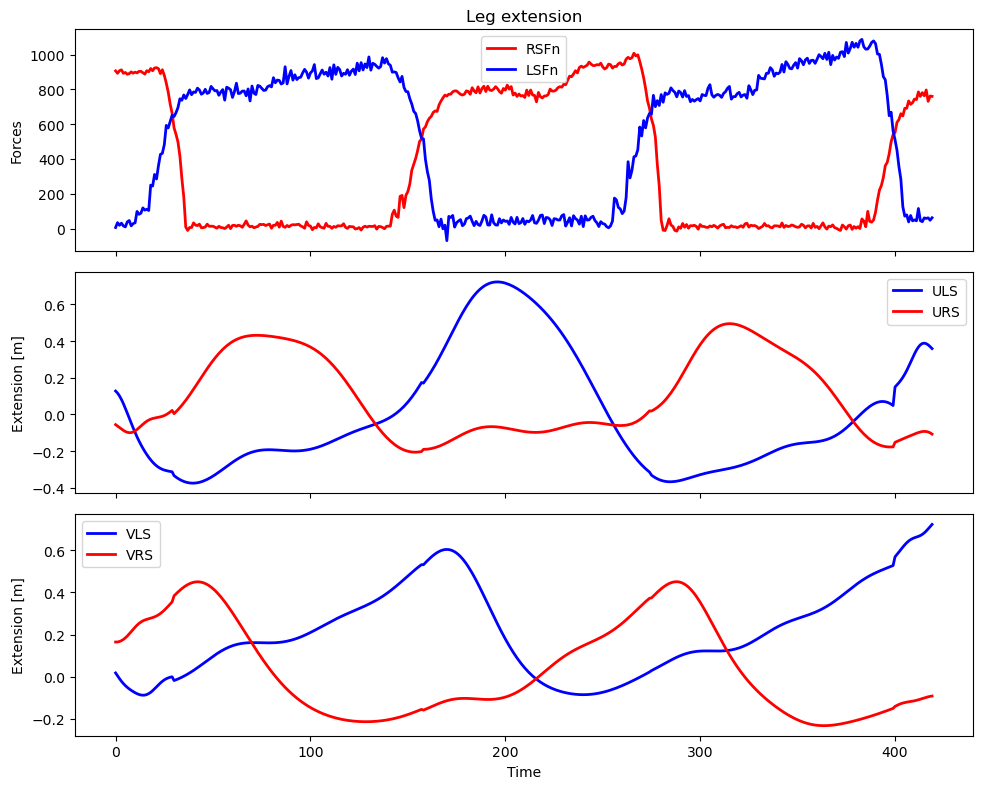

In [5]:
############### Plotting the leg extension (input, measured) #################
fig, a = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plotting on the first subplot
a[0].plot(RSFn, 'r', linewidth=2, label='RSFn')
a[0].plot(LSFn, 'b', linewidth=2, label='LSFn')
a[0].grid(which='minor', linestyle=':', linewidth='0.5')
a[0].set_ylabel('Forces')
a[0].set_title('Leg extension')
a[0].legend()

a[1].plot(ULS, 'b', linewidth=2, label='ULS')
a[1].plot(URS, 'r', linewidth=2, label='URS')
a[1].grid(which='minor', linestyle=':', linewidth='0.5')
a[1].set_ylabel('Extension [m]')
a[1].legend()

a[2].plot(VLS, 'b', linewidth=2, label='VLS')
a[2].plot(VRS, 'r', linewidth=2, label='VRS')
a[2].grid(which='minor', linestyle=':', linewidth='0.5')
a[2].set_ylabel('Extension [m]')
a[2].legend()

# Link the x-axes of all subplots
plt.xlabel('Time')
plt.tight_layout()
plt.show()


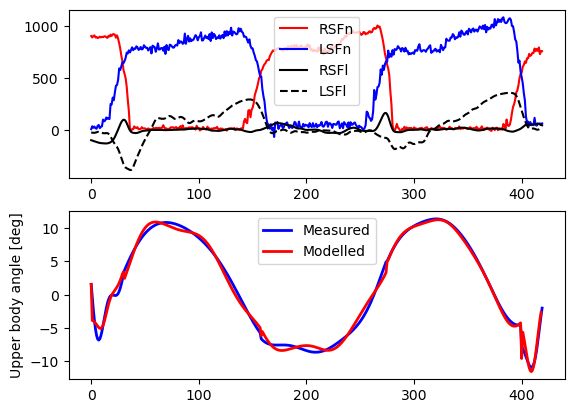

In [6]:
# Convert radians to degrees
def rad2deg(radians):
    return np.degrees(radians)


#Plot the normal and lateral forces and upper body position (measured and modelled)
fig, a5 = plt.subplots(2, 1)

# Forces 
a5[0].plot(RSFn, 'r', label='RSFn')
a5[0].plot(LSFn, 'b', label='LSFn')
a5[0].plot(RSFl, 'k', label='RSFl')
a5[0].plot(LSFl, '--k', label='LSFl')
a5[0].grid(True, which='minor')
a5[0].legend()

# Measured and simulated body angle 
a5[1].plot(rad2deg(THETA_B), 'b', linewidth=2, label='Measured')
a5[1].plot(rad2deg(thetab), 'r', linewidth=2, label='Modelled')
a5[1].set_ylabel('Upper body angle [deg]')
a5[1].grid(True, which='minor')
a5[1].legend()

plt.show()

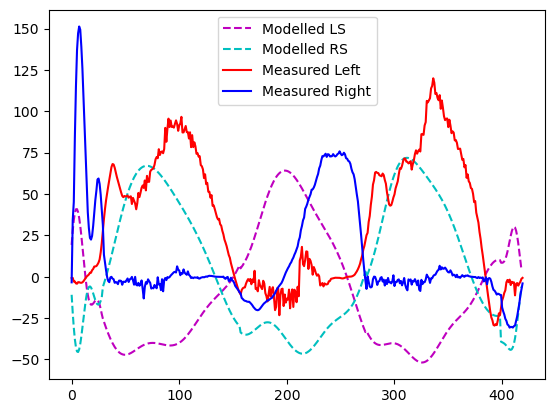

In [7]:
#MEasured forces in x direction, in global axis
plt.figure()

#Modelled forces 

GForceLS_sin_THETA_LS = -GForceLS[:, 0] * np.sin(THETA_LS)
GForceRS_sin_THETA_RS = GForceRS[:, 0] * np.sin(THETA_RS)
SkateLabdas_globalls= SkateLabdas[0,:] * np.sin(THETA_LS[1:])
SkateLabdas_globalrs = SkateLabdas[0,:] * np.sin(THETA_RS[1:])

plt.plot(SkateLabdas_globalls, 'm--', label='Modelled LS')
plt.plot(SkateLabdas_globalrs, 'c--', label='Modelled RS')
plt.plot(GForceLS_sin_THETA_LS, 'r', label='Measured Left')
plt.plot(GForceRS_sin_THETA_RS, 'b', label='Measured Right')
#plt.plot(SkateForces)
plt.legend()
plt.grid(True, which='minor')
plt.show()

In [ ]:
# F_wrijvy = -F_wrijvb * np.cos(thetab) - F_wrijv * np.cos(thetab)
# F_wrijvx = F_wrijvb * np.sin(thetab) + F_wrijv * np.sin(thetab)


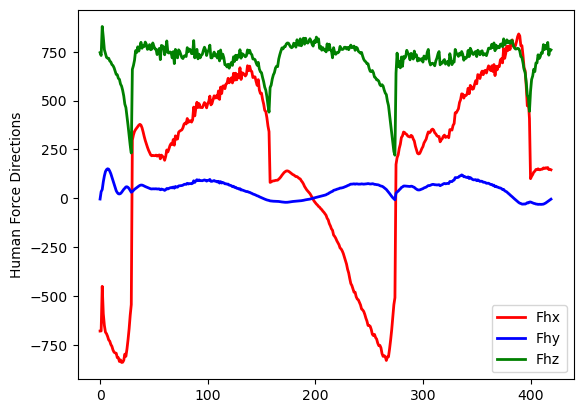

In [11]:
import numpy as np

# Assuming THETA_LS, skate_Array, T2, THETA_LS, GForceLS, THETA_RS, and GForceRS are defined elsewhere in your code

# Initialize arrays to store the results
Fhy = np.zeros(len(THETA_LS))
Fhx = np.zeros(len(THETA_LS))
Fhz = np.zeros(len(THETA_LS))

# Calculate measured forces in the global coordinate system
for i in range(len(THETA_LS)):
    if skate_Array[0][i] == 1:
        Fhy[i] = -GForceLS[i, 0] * np.sin(THETA_LS[i])
        Fhx[i] = -GForceLS[i, 0] * np.cos(THETA_LS[i])
        Fhz[i] = GForceLS[i, 1]
    else:
        Fhy[i] = GForceRS[i, 0] * np.sin(THETA_RS[i])
        Fhx[i] = -GForceRS[i, 0] * np.cos(THETA_RS[i])
        Fhz[i] = GForceRS[i, 1]

plt.figure()
#FOrces measured 
plt.plot(Fhx, 'r', linewidth=2, label='Fhx')
plt.plot(Fhy, 'b', linewidth=2, label='Fhy')
plt.plot(Fhz, 'g', linewidth=2, label='Fhz')

# Add legend, ylabel, and grid
plt.legend()
plt.ylabel('Human Force Directions')
plt.grid(which='minor')
plt.show()


NameError: name 'thetas' is not defined

<Figure size 640x480 with 0 Axes>

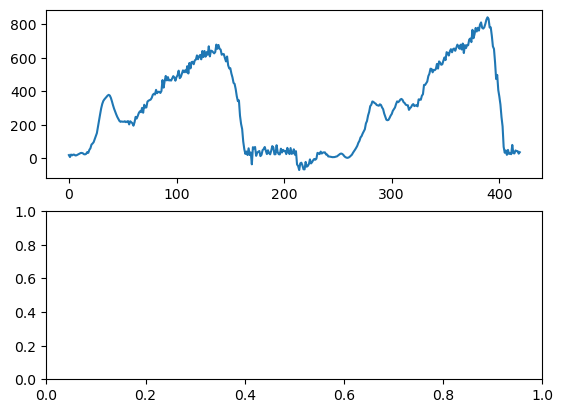

In [12]:
plt.figure()

GForceRS_y, GForceLS_y, GForceRS_x, GForceLS_x = np.zeros(len(THETA_LS)), np.zeros(len(THETA_LS)), np.zeros(len(THETA_LS)), np.zeros(len(THETA_LS))


# for i in range(len(THETA_LS)):
#     GForceLS_y[i] = -GForceLS[i, 0] * np.sin(THETA_LS[i])
#     GForceRS_y[i] = GForceRS[i, 0] * np.sin(THETA_RS[i])
#     GForceLS_x[i] = -GForceLS[i, 0] * np.cos(THETA_LS[i])
#     GForceRS_x[i] = GForceRS[i, 0] * np.cos(THETA_RS[i])
#     #SkateLabdas_globalls= SkateLabdas[0,:] * np.sin(THETA_LS[1:])
#     #SkateLabdas_globalrs = SkateLabdas[0,:] * np.sin(THETA_RS[1:])

# fig, axs = plt.subplots(2, 1)    
# axs[0].plot(GForceLS_x)
# axs[0].plot(SkateForces[:,0]*np.cos(thetas))
# axs[0].set_xlabel('Index')
# axs[0].set_ylabel('x values')

# # Plot y
# axs[1].plot(GForceLS_y)
# axs[1].plot(SkateForces[:,1])
# axs[1].set_xlabel('Index')
# axs[1].set_ylabel('y values')

# # # # Plot z
# # # axs[2].plot()
# # # axs[2].set_title('Plot of z')
# # # axs[2].set_xlabel('Index')
# # # axs[2].set_ylabel('z values')
# # #plt.plot(SkateLabdas_globalls, 'm--', label='Modelled LS')
# # #plt.plot(SkateLabdas_globalrs, 'c--', label='Modelled RS')
# # plt.plot(GForceLS_y, 'r', label='Measured Left y')
# # plt.plot(GForceRS_y, 'b', label='Measured Right y')
# # plt.plot(GForceLS_x, 'r', label='Measured Left x')
# # plt.plot(GForceRS_x, 'b', label='Measured Right x')
# # plt.plot(SkateForces, label='SkateForces')
# # #plt.plot(SkateForces)
# # plt.legend()
# # plt.grid(True, which='minor')
# plt.show()